In [16]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
np.random.seed(0) #makes the random numbers predictable for reproducibility

from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.preprocessing import sequence

from IPython import display
import warnings, time, os
warnings.filterwarnings("ignore")

In [2]:
# Creating dataframe from function_assignment.csv
data = pd.read_csv('function_assignment.csv')

data.head(n=5)

,function,job_title,jds
0,Sales/ Business Development/ Account Management,Head - Digital Portfolio,NaN
1,IT/ Information Technology,Software Head,10-15 years of experience in a VFX facility Ad...
2,Software Architecting,iPhone Developers,Candidate Should have Strong OO design and pro...
3,Software Architecting,Html/css Developer Job,Job Description Must have at -least . Years ex...
4,Software Architecting,Asp.net Developer Job,Develop ASP.netweb applicationsPerform unit te...


In [3]:
#Checking which fields contain empty values
pd.isnull(data).sum()

function        0
job_title       0
jds          1796
dtype: int64

In [4]:
data.describe()

,function,job_title,jds
count,10145,10145,8349
unique,351,7236,6846
top,Sales/ Business Development/ Account Management,Business Development Manager,"Managing the team of Branch Managers, ABM, Sal..."
freq,1245,41,24


In [5]:
df = data.drop('job_title', axis = 1)
df = df.dropna()
df = df[df['jds'].str.len() > 10]
df.head(n=10)

,function,jds
1,IT/ Information Technology,10-15 years of experience in a VFX facility Ad...
2,Software Architecting,Candidate Should have Strong OO design and pro...
3,Software Architecting,Job Description Must have at -least . Years ex...
4,Software Architecting,Develop ASP.netweb applicationsPerform unit te...
6,Project/ Program Management IT,Job Description Job holder may need to work o...
8,Sales/ Business Development/ Account Management,Job Description Primary roe of Inside sales A...
9,Design,Reporting to: Design Leader PURPOSE: To conve...
10,"Creative, Software Design & Development",Role : Graphics Software Engineer Education :...
13,Software Design & Development,Job Title: UI Developer
14,"Creative, Testing - Software",Looking for an Unity3D Developer who will be w...


In [6]:
#Removing functions which are only mentioned a few times. Cutoff value is equal to cutoff_for_function_count.
# These functions have insufficient data and will not be classified correctly. It's better to remove them

d = defaultdict()

for index, row in df.iterrows():
    fun = row[0]
    if fun in d.keys():
        d[fun] = d[fun] + 1
    else:
        d[fun] = 1

cutoff_for_function_count = 50

df['temp'] = 'NA'
for index, row in df.iterrows():
    if d[row[0]] > cutoff_for_function_count:
        row[2] = 'True'
    else:
        row[2] = 'False'
        
df = df[df['temp'] == 'True']
df = df.drop('temp', axis=1)
df.head(n=5)

,function,jds
1,IT/ Information Technology,10-15 years of experience in a VFX facility Ad...
2,Software Architecting,Candidate Should have Strong OO design and pro...
3,Software Architecting,Job Description Must have at -least . Years ex...
4,Software Architecting,Develop ASP.netweb applicationsPerform unit te...
6,Project/ Program Management IT,Job Description Job holder may need to work o...


In [7]:
X = df.values[:,1]
Y = df.values[:,0]
# Replacing '.' with '' to reduce vocab otherwise word ending with a '.' are counted as new word.
# If we try to use '.' , NLTK word_tokenize is also failing to recognise non-technical words
X = np.array([i.lower().replace('.','') for i in X])
Y = np.array([i.lower().replace('.','') for i in Y])
print(X.shape)
print(Y.shape)

(6822,)
(6822,)


In [8]:
print(X[0])
print('\n',Y[0])

10-15 years of experience in a vfx facility advanced knowledge of c++, python exp with maya (both as user and developer) exp with linux (or other unix) operating system exp using development best practices exp leading a team of developers managing relationships with supervisors, key artists and production staff working closely with the other heads of software and head of technology to address current challenges and implement future strategy identifying changing requirements and recommending solutions leading the bangalore software department and closely working with local software leads and developers to resolve issues and ensure that implementations are consistent with overall software department strategy drive and continuously improve the departments working and development practices continuously mentor and guide team members to grow the team and individual skill levels

 it/ information technology


In [9]:
np.set_printoptions(threshold=np.nan)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
encoded_Y = np_utils.to_categorical(encoded_Y)
print('encoded_Y shape:',encoded_Y.shape)
print('First Y category number:',np.argmax(encoded_Y[0]))
print(encoded_Y[0])
np.set_printoptions(threshold=10)

encoded_Y shape: (6822, 27)
First Y category number: 6
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


[array([ 430.,   17.]), array([ 1404.5,  2862. ])]


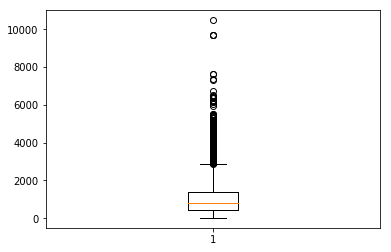

In [10]:
plt.close()
keywords_length = list(df.jds.str.len())
plot = plt.boxplot(keywords_length)
print([item.get_ydata() for item in plot['whiskers']])
plt.show()

In [11]:
X_word_list = np.array(list(set((' '.join(X).split()))))
X_word_list.shape

(38178,)

In [12]:
np.set_printoptions(threshold=np.nan)
encoder = LabelEncoder()
encoder.fit(X_word_list)
# convert integers to dummy variables (i.e. one hot encoded)
encoded_X = np.array([encoder.transform(i.split()) for i in X])

In [13]:
encoded_X = np.array(encoded_X)
print('X shape:',encoded_X.shape)
print(encoded_X[0])
np.set_printoptions(threshold=10)

X shape: (6822,)
[ 3576 37860 25178 15677 19271  4996 36734 15955  5617 21086 25178  8907
 28795 15606 37513 22902   571  6904 36352  6319 13169 15606 37513 21838
  1743 25846 36138 25509 34240 15606 36382 13187  8016 27600 15606 21485
  4996 34574 25178 13175 22542 29809 37513 33986 21007  6895  6319 28174
 33235 37614 10155 37513 34967 25846 18200 25178 32696  6319 18173 25178
 34703 35267  5498 12158  9645  6319 19158 17206 33618 18952  9682 30106
  6319 29468 32759 21485 34967  7634 32696 12883  6319 10155 37614 37513
 21964 32696 21490  6319 13175 35267 30207 20512  6319 14932 34962 19173
  6790 11169 37513 25973 32696 12883 33618 13998  6319 11344 19220 34967
 12893 37614  6319 13187 27600 11344 23227  6319 17907 34574 23165 35267
 17835 34967 34574  6319 19502 32427 21633]


In [19]:
top_words = X_word_list.shape[0]
maxlen = 1500
max_features = 200
batch_size = 8

#Truncating and padding sentences
X_final = sequence.pad_sequences(encoded_X, maxlen=maxlen, padding='pre', truncating='post', value=0.)

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
# Write in console -> tensorboard --logdir path_to_current_dir/Graph 
# Open in browser -> localhost:6006
try:
    print('Loading model...')
    model = load_model('model.h5')
except:
    print('Building model...')
    model = Sequential()
    model.add(Embedding(input_dim = top_words, output_dim = max_features, input_length=maxlen))
    model.add(LSTM(64, return_sequences=True))  
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))  
    model.add(Dropout(0.3))
    model.add(LSTM(32))  
    model.add(Dropout(0.4))
    model.add(Dense(encoded_Y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
model.save('model.h5')

print("Training started...")
model.fit(X_final, encoded_Y, batch_size=batch_size, epochs=5, validation_split=0.1, callbacks=[tbCallBack])

Loading model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 200)         7635600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 1500, 64)          67840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1500, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1500, 64)          33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1500, 64)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0   